# Retina Blood Vessel UNET


In [1]:
!pip install imantics --quiet

In [2]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
images_dir ='/kaggle/input/retina-blood-vessel/Data/train/image'
masks_dir = '/kaggle/input/retina-blood-vessel/Data/train/mask'

In [4]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [5]:
print(len(images_listdir))
print(len(masks_listdir))

80
80


In [6]:
image_size=512
input_image_size=(512,512)

In [7]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [8]:
number=200

# Input images 

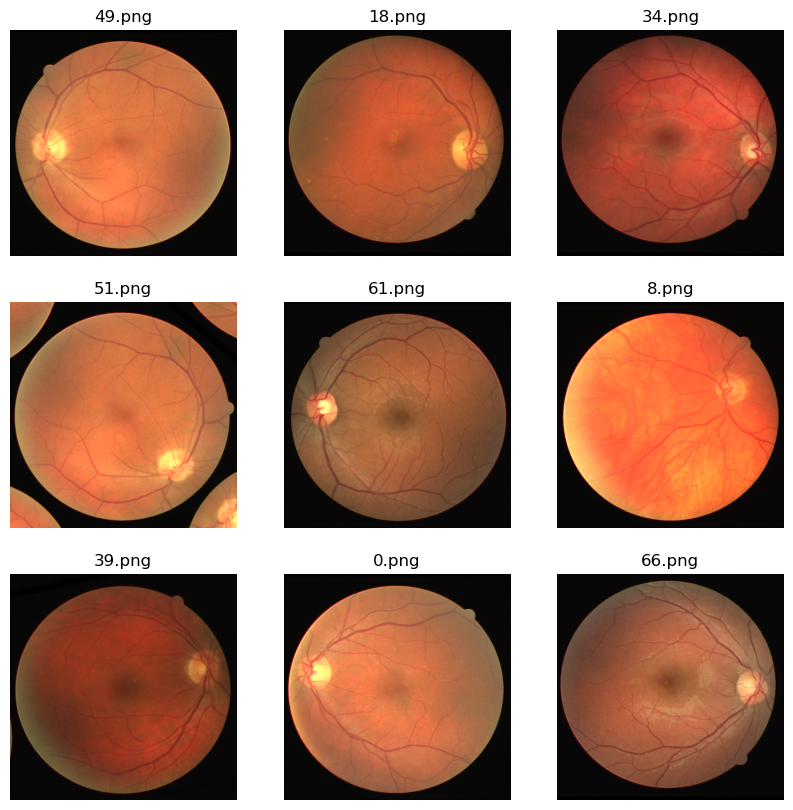

In [9]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

# Ground truth masks

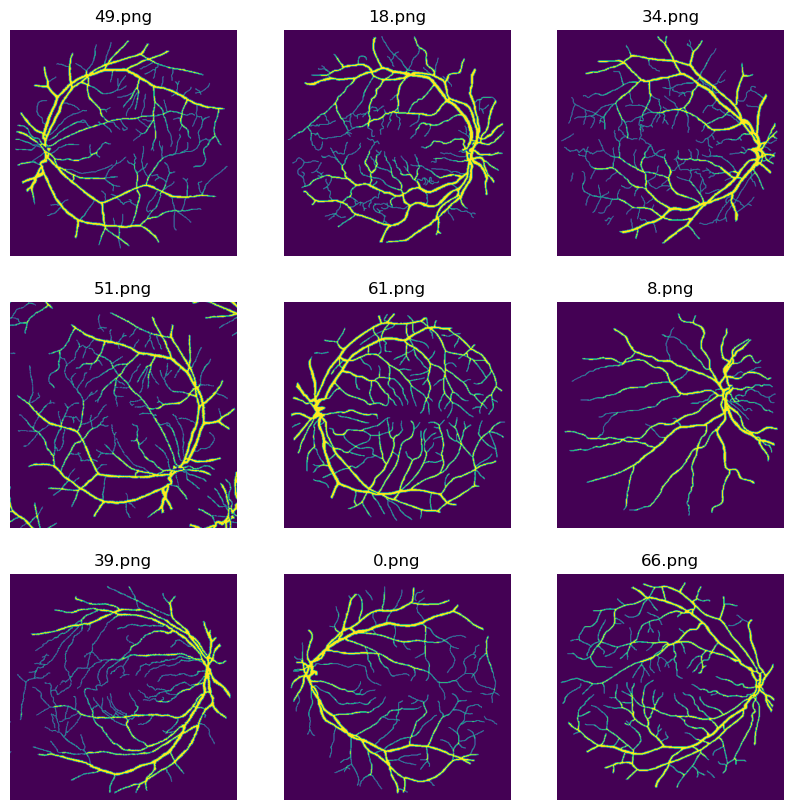

In [10]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [11]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}") 
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)    
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [12]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(80, 512, 512, 3) (80, 512, 512, 1)


In [13]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [14]:
print(len(images_train), len(masks_train))

48 48


# U-Net

In [15]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#unet_model.summary()

# Train
Suitable number epoch range is narrow.

In [16]:
unet_result = unet_model.fit(
    images_train, masks_train, 
    validation_split = 0.2, batch_size = 4, epochs = 20)

Epoch 1/20
10/10 [==============================] - 42s 1s/step - loss: -150.0336 - accuracy: 0.3784 - val_loss: -4376.2344 - val_accuracy: 0.0010
Epoch 2/20
10/10 [==============================] - 4s 435ms/step - loss: -349.0699 - accuracy: 0.6671 - val_loss: -13998.0420 - val_accuracy: 5.5428e-04
Epoch 3/20
10/10 [==============================] - 4s 435ms/step - loss: -403.7699 - accuracy: 0.4654 - val_loss: 480.0793 - val_accuracy: 0.8328
Epoch 4/20
10/10 [==============================] - 4s 435ms/step - loss: -448.4081 - accuracy: 0.3344 - val_loss: 12.4659 - val_accuracy: 0.6675
Epoch 5/20
10/10 [==============================] - 4s 436ms/step - loss: -486.9435 - accuracy: 0.3186 - val_loss: -1385.0573 - val_accuracy: 0.0015
Epoch 6/20
10/10 [==============================] - 4s 436ms/step - loss: -520.4214 - accuracy: 0.3174 - val_loss: -2853.6277 - val_accuracy: 6.8588e-04
Epoch 7/20
10/10 [==============================] - 4s 436ms/step - loss: -561.8073 - accuracy: 0.3159 -

# Predict valid images

In [17]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [18]:
unet_predict = unet_model.predict(images_test)

1/1 [==============================] - 30s 30s/step


In [19]:
len(images_test)

32

In [20]:
r1,r2,r3,r4=0.7,0.8,0.9,0.99

In [21]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

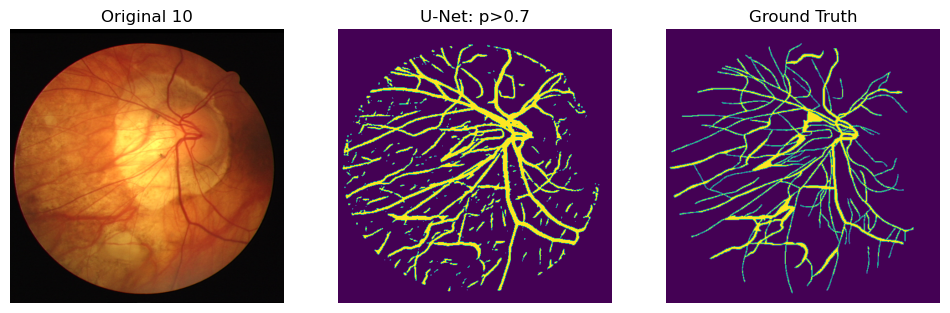

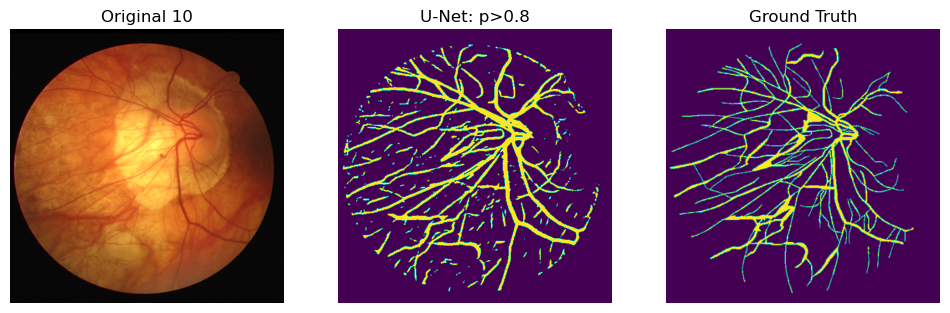

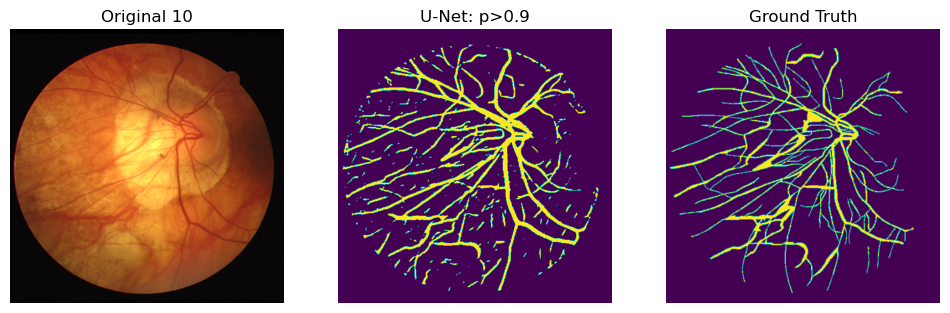

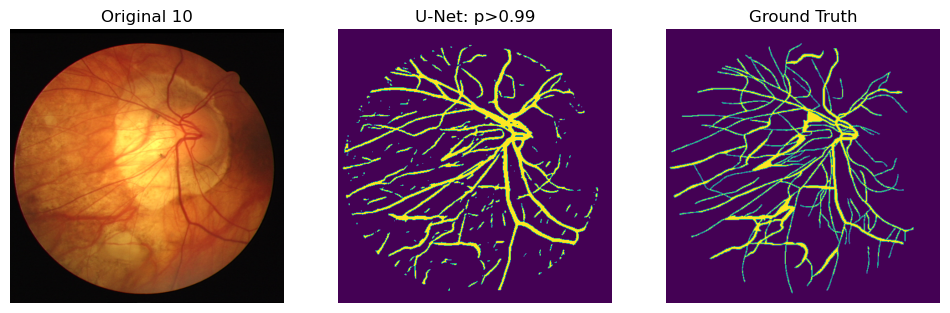

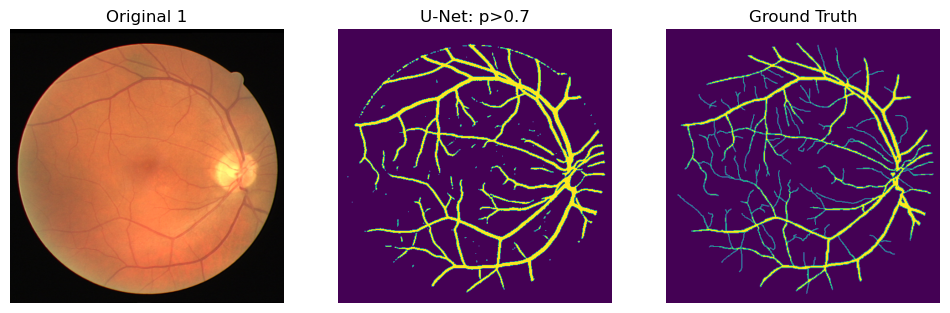

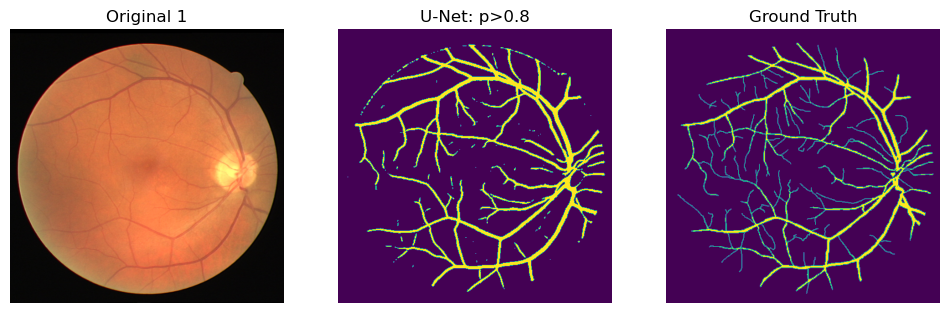

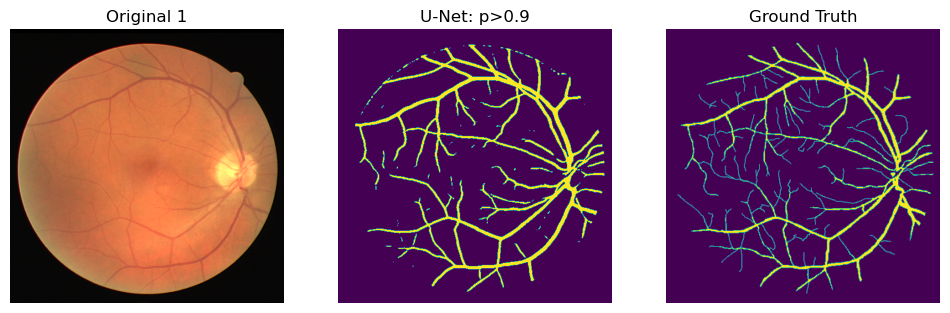

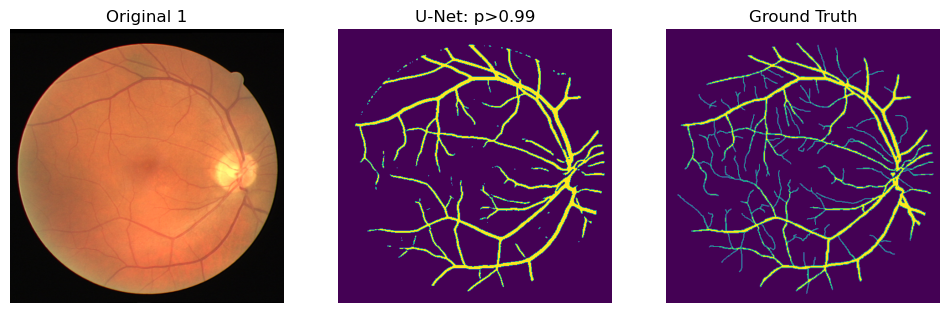

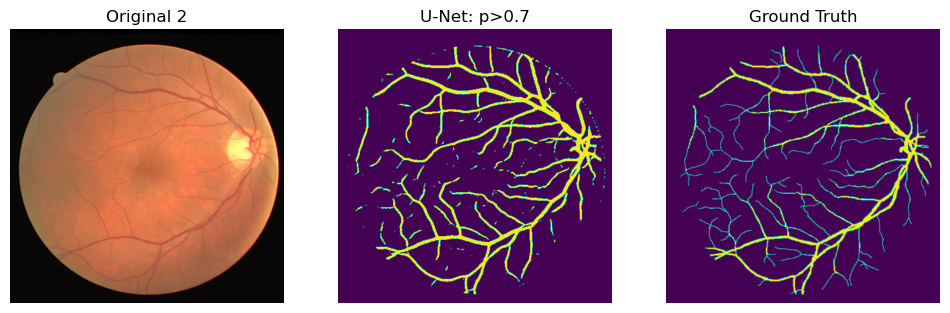

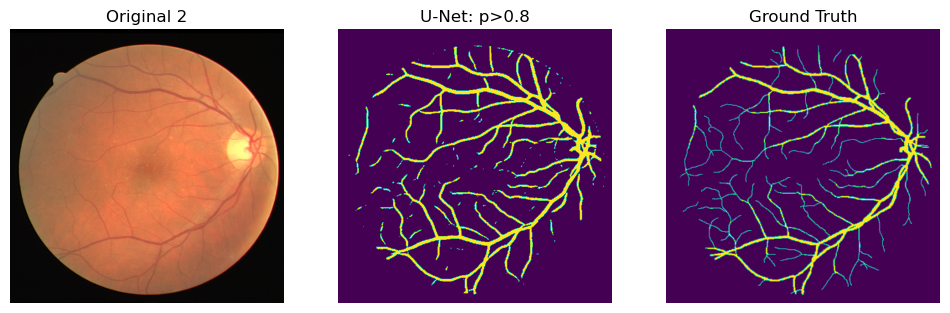

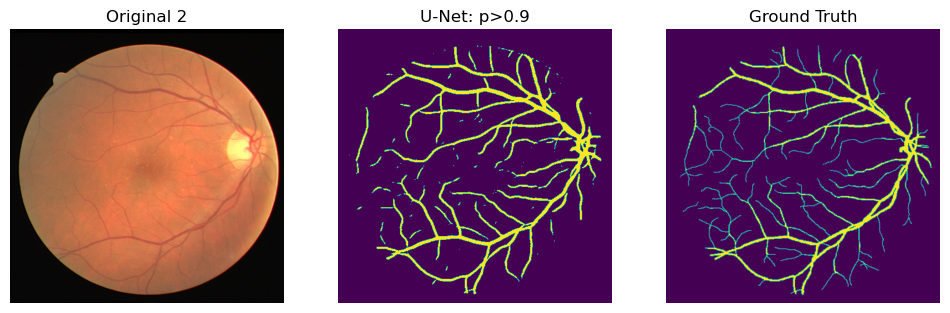

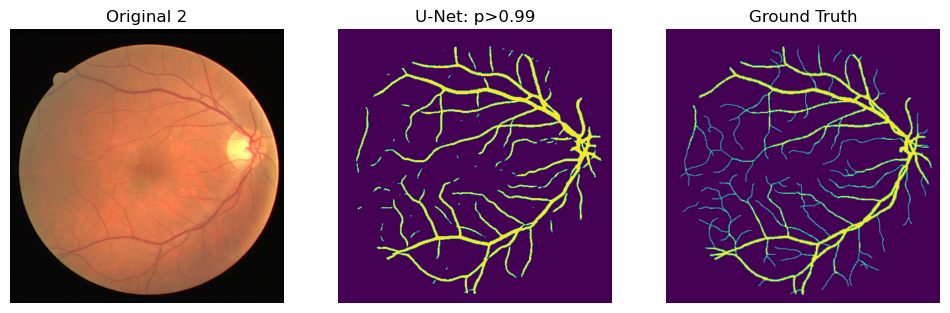

In [22]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx: 
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/retina-blood-vessel/Data/test/mask/11.png
/kaggle/input/retina-blood-vessel/Data/test/mask/4.png
/kaggle/input/retina-blood-vessel/Data/test/mask/9.png
/kaggle/input/retina-blood-vessel/Data/test/mask/14.png
/kaggle/input/retina-blood-vessel/Data/test/mask/1.png
/kaggle/input/retina-blood-vessel/Data/test/mask/2.png
/kaggle/input/retina-blood-vessel/Data/test/mask/10.png
/kaggle/input/retina-blood-vessel/Data/test/mask/18.png
/kaggle/input/retina-blood-vessel/Data/test/mask/12.png
/kaggle/input/retina-blood-vessel/Data/test/mask/7.png
/kaggle/input/retina-blood-vessel/Data/test/mask/17.png
/kaggle/input/retina-blood-vessel/Data/test/mask/5.png
/kaggle/input/retina-blood-vessel/Data/test/mask/3.png
/kaggle/input/retina-blood-vessel/Data/test/mask/16.png
/kaggle/input/retina-blood-vessel/Data/test/mask/8.png
/kaggle/input/retina-blood-vessel/Data/test/mask/6.png
/kaggle/input/retina-blood-vessel/Data/test/mask/15.png
/kaggle/input/retina-blood-vessel/Data/test/mask/13.png
/

In [24]:
from keras.utils import normalize
import os
import cv2 as cv
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [25]:
image_directory_train="/kaggle/input/retina-blood-vessel/Data/train/image"
mask_directory_train="/kaggle/input/retina-blood-vessel/Data/train/mask"
image_directory_test="/kaggle/input/retina-blood-vessel/Data/test/image"
mask_directory_test="/kaggle/input/retina-blood-vessel/Data/test/mask"

In [26]:
SIZE = 256
train_image_dataset = []   
train_mask_dataset = []
test_image_dataset = []   
test_mask_dataset = []

In [27]:
train_images = os.listdir(image_directory_train)

In [28]:
for i, image_name in enumerate(train_images):    
    if (image_name.split('.')[1] == 'png'):
#         print(image_directory_train+"/"+image_name)
        image = cv.imread(image_directory_train+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_image_dataset.append(np.array(image))

In [29]:
train_masks = os.listdir(mask_directory_train)
for i, image_name in enumerate(train_masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(mask_directory_train+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_mask_dataset.append(np.array(image))

In [30]:
#Normalize images
train_image_dataset = np.expand_dims(normalize(np.array(train_image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
train_mask_dataset = np.expand_dims((np.array(train_mask_dataset)),3) /255.

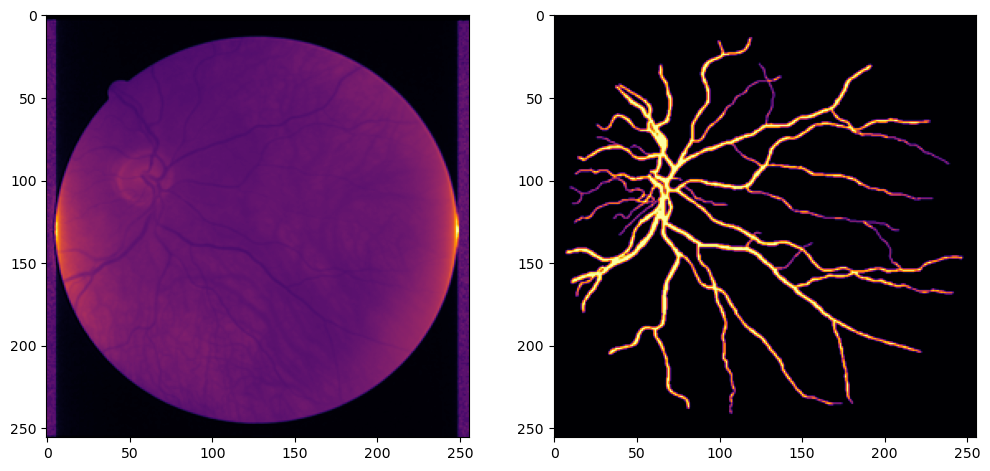

In [31]:
import random
import numpy as np
image_number = random.randint(0, len(train_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(train_image_dataset[image_number], (256, 256)),cmap="inferno")
plt.subplot(122)
plt.imshow(np.reshape(train_mask_dataset[image_number], (256, 256)),cmap="inferno")
plt.show()

In [32]:
test_images = os.listdir(image_directory_test)
test_masks = os.listdir(mask_directory_test)

In [33]:
for i, image_name in enumerate(test_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(image_directory_test+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_image_dataset.append(np.array(image))

In [34]:
for i, image_name in enumerate(test_masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(mask_directory_test+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_mask_dataset.append(np.array(image))

In [35]:
#Normalize images
test_image_dataset = np.expand_dims(normalize(np.array(test_image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
test_mask_dataset = np.expand_dims((np.array(test_mask_dataset)),3) /255.

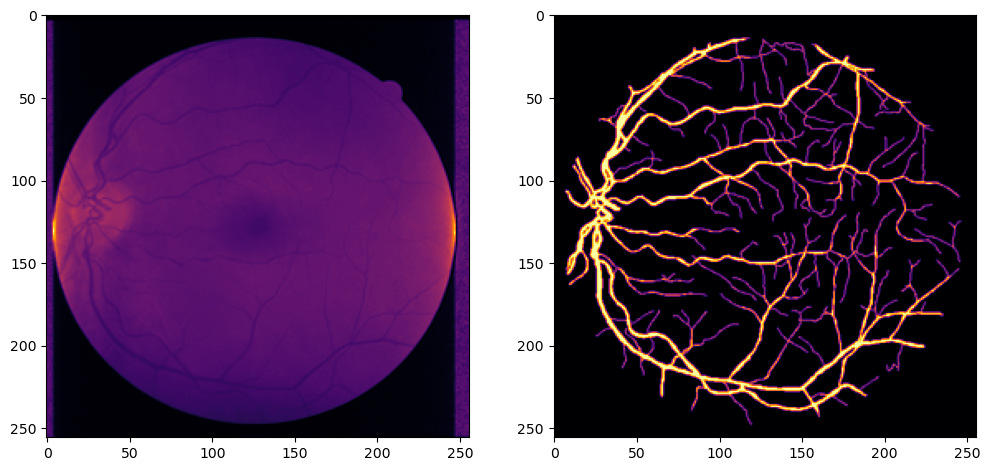

In [36]:
image_number = random.randint(0, len(test_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(test_image_dataset[image_number], (256, 256)),cmap="inferno")
plt.subplot(122)
plt.imshow(np.reshape(test_mask_dataset[image_number], (256, 256)),cmap="inferno")
plt.show()

In [37]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D,  concatenate, Conv2DTranspose, BatchNormalization, Dropout

In [38]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [39]:
IMG_HEIGHT = train_image_dataset.shape[1]
IMG_WIDTH  = train_image_dataset.shape[2]
IMG_CHANNELS = train_image_dataset.shape[3]

In [40]:
model= simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                             

In [41]:
history = model.fit(train_image_dataset, train_mask_dataset, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=80, 
                    validation_data=(test_image_dataset, test_mask_dataset), 
                    shuffle=False)

Epoch 1/80


2023-10-30 18:04:36.526836: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3/3 [==============================] - 15s 2s/step - loss: 0.9970 - accuracy: 0.4382 - val_loss: 0.6591 - val_accuracy: 0.5977
Epoch 2/80
3/3 [==============================] - 0s 158ms/step - loss: 0.7367 - accuracy: 0.6885 - val_loss: 0.7344 - val_accuracy: 0.5548
Epoch 3/80
3/3 [==============================] - 0s 161ms/step - loss: 0.8162 - accuracy: 0.7927 - val_loss: 1.9646 - val_accuracy: 0.2738
Epoch 4/80
3/3 [==============================] - 1s 165ms/step - loss: 1.0468 - accuracy: 0.8040 - val_loss: 1.4147 - val_accuracy: 0.4508
Epoch 5/80
3/3 [==============================] - 0s 159ms/step - loss: 1.4883 - accuracy: 0.7638 - val_loss: 1.2185 - val_accuracy: 0.5846
Epoch 6/80
3/3 [==============================] - 0s 159ms/step - loss: 3.7216 - accuracy: 0.5598 - val_loss: 4.9817 - val_accuracy: 0.5822
Epoch 7/80
3/3 [==============================] - 0s 158ms/step - loss: 52.8864 - accuracy: 0.5525 - val_loss: 229.5210 - val_accuracy: 0.6802
Epoch 8/80
3/3 [==============

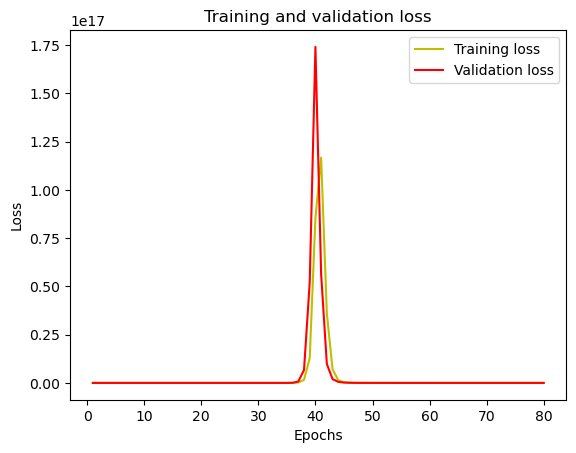

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()